## DATA 603 - MACHINE LEARNING

## THU CAO

In [72]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from scipy import io as spio
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score

# Face Dataset

In [74]:
#data=spio.loadmat('/content/drive/MyDrive/Face_Recognition/data.mat')
data = spio.loadmat('data.mat')

In [75]:
#stack the sequence of input arrays vertically to make a single array
X = data['face'].transpose(2, 0, 1)
print(X.shape)
X = np.vstack([np.concatenate(X[i], axis=0) for i in range(len(X))])
y = np.array([(i%3) for i in range(len(X))])
print(X.shape)
X[0, 0: 5]

(600, 24, 21)
(600, 504)


array([-1.66302198, -1.8737163 , -1.8737163 , -1.8737163 , -1.8737163 ])

In [76]:
# FUNCTION TO AUGMENT THE IMAGES (FLIP) - automatic way to boost the number of different images that will be used to train model

def augment(faces, target):
  n_samples = faces.shape[0]
  print("No of samples before augmentation = ", n_samples)
  for i in range(n_samples):
    face = np.array(faces[i, :,:])
    flipped_face = np.flip(face, 1).reshape(1, face.shape[0], face.shape[1])    # Creates a flipped image
    faces = np.append(faces, flipped_face, axis = 0)                            # Appends the image to the dataset
    target = np.append(target, [target[i]], axis = 0)                           # Appends the target to the dataset
  return faces, target

Face matrix shape =  (600, 24, 21)
No of samples before augmentation =  600
Faces data shape =  (1200, 504)
Total samples =  1200


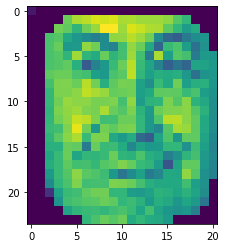

In [77]:
# LOAD THE FACE DATA AND CREATE TARGET LABELS

def load_data(raw_data):
  face=raw_data['face'].transpose(2, 0, 1)                                      # Load dataset from the raw dictionary
  plt.imshow(face[1, :, :])
  print("Face matrix shape = ", face.shape)
  target_data = []
  for i in range(face.shape[0]):
    target_data.append([i%3])                                                   # Creating the target labels (as facial images are arranged in periodic order)
  target_data = np.array(target_data)
  face, target_data = augment(face, target_data)                                # Double the dataset by flipping the images
  faces_data = np.vstack([np.concatenate(face[i], axis = 0) for i in range(len(face))])   # Flatten the face matrix into feature like representation
  print("Faces data shape = ", faces_data.shape)
  data = np.concatenate((faces_data, target_data), axis = 1)
  df= pd.DataFrame(data)

  return df

df = load_data(data)
print("Total samples = ", df.shape[0])

In [78]:
# FUNCTION TO STANDARDIZE THE VALUES FOR BETTER PCA PERFORMANCE

def standardize(df, s, avg = None, std = None):
  if s == "train":                                          # If train set then store the mean and standard deviation for the features and scale the features
    avg = {}
    std = {}
    for col in df.columns:
      if col != 504:
        feature = np.array(df.loc[:,col])
        avg[col] = np.mean(feature)                         # Storing the mean
        std[col] = np.std(feature)                          # Storing the standard deviation
        feature = (feature - avg[col])/std[col]             # Scale the feature
        temp = {col:feature}
        df.loc[:, col] = feature
    return df, avg, std
  
  if s == "val":
    for col in df.columns:
      if col != 504:
        feature = np.array(df.loc[:, col])
        feature = (feature - avg[col])/std[col]             # Scale the feature using mean and std from train set
        temp = {col : feature}
        df.loc[:, col] = feature

    return df

# SPLITTING TRAINING AND VALIDATION SET: 25% TEST SIZE

# using validation dataset as a sample of data held back from training model that is used to give an estimate of model skill while tuning model’s hyperparameters.
# Validation Dataset used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. 

train_df, val_df = train_test_split(df, test_size = 0.25, shuffle = True)
train_df, avg, std = standardize(train_df, "train")
print(train_df.head())
val_df = standardize(val_df, "val", avg, std)
print("No of training examples = ", train_df.shape[0])
print("No of Validation Examples = ", val_df.shape[0])

           0         1         2         3         4         5         6    \
310  -0.140570 -0.947278 -0.947278 -0.947278 -0.947278 -0.947278 -0.947278   
306  -0.439271 -1.317474 -1.317474 -1.317474 -1.317474 -1.317474 -1.317474   
1166  0.429215  1.645381  1.645381  1.645381  1.645381  1.645381  1.645381   
183   0.150314 -0.248373 -0.248373 -0.248373 -0.248373 -0.248373 -0.248373   
456   0.000789 -0.483896 -0.483896 -0.483896 -0.483896 -0.483896 -0.483896   

           7         8         9    ...       495       496       497  \
310  -0.947278 -0.947278 -0.947278  ...  0.976691  1.160720  1.161830   
306  -1.317474 -1.317474 -1.317474  ...  0.216945  0.490054  0.070717   
1166  1.645381  1.645381  1.645381  ... -1.250027 -1.795630 -1.380335   
183  -0.248373 -0.248373 -0.248373  ... -1.333567 -0.736307 -1.407965   
456  -0.483896 -0.483896 -0.483896  ...  1.533443  1.310909  0.949533   

           498       499       500       501       502       503  504  
310   1.246559 -0.94

/Users/Thuy/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/Thuy/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [79]:
for col in train_df.columns:
  if abs(np.mean(train_df[col])) > 1e-5:
    print(np.mean(train_df[col]))

1.0077777777777779


### TRAIN AND VALIDATION TARGET DISTRIBUTION

In [80]:
train_target = train_df[504]
print("Train Target Distribution :\n", np.unique(train_target, return_counts = True))
val_target = val_df[504]
print("Val Target Distribution :\n", np.unique(val_target, return_counts = True))

Train Target Distribution :
 (array([0., 1., 2.]), array([297, 299, 304]))
Val Target Distribution :
 (array([0., 1., 2.]), array([103, 101,  96]))


### PLOTTING ONE EXAMPLE

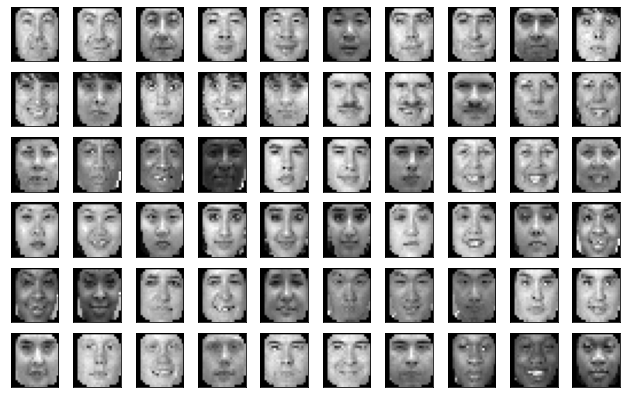

In [81]:
# FUNCTION TO SHOW THE FACES

def show_orignal_images(pixels):
  pixels = pixels.iloc[:,:-1]
  fig, axes = plt.subplots(6, 10, figsize=(11, 7), subplot_kw={'xticks':[], 'yticks':[]})
  for i, ax in enumerate(axes.flat):
    ax.imshow(np.array(pixels)[i].reshape(24, 21), cmap='gray')
  plt.show()

show_orignal_images(df)

## Pre-Processing PCA and MDA

In [82]:
# FUNCTION TO SHOW THE IMAGES ON EIGEN VECTOR AXES

def show_eigenfaces(pca):
	#Displaying Eigenfaces
	fig, axes = plt.subplots(3, 8, figsize=(9, 4),
	                         subplot_kw={'xticks':[], 'yticks':[]})
	for i, ax in enumerate(axes.flat):
	    ax.imshow(pca.components_[i].reshape(24, 21), cmap='gray')
	    ax.set_title("PC " + str(i+1))
	plt.show()

In [83]:
# FUNCTION TO APPLY PCA ON TRAIN AND VALIDATION DATASETS

def apply_PCA(x_train, x_val, pca):
  x_train_pca = pca.transform(x_train)                # Transforming the Train Set
  x_val_pca = pca.transform(x_val)                    # Transforming the Validation Set
  
  return x_train_pca, x_val_pca

# FUNCTION TO ANALYZE THE VARIANCE FOR DIFFERENT PCA COMPONENT VALUES

def PCA_analysis(train, val, n_comp):
  x_train = train.iloc[:,:-1]
  y_train = train.iloc[:, -1:]
  x_val = val.iloc[:,:-1]
  y_val = val.iloc[:, -1:]
  n_comp = min(n_comp, len(train))                        # Because n_comp < len(train_set)
  pca = PCA(n_components=n_comp).fit(x_train)             # Fitting PCA on train set
  plt.plot(np.cumsum(pca.explained_variance_ratio_))     # plot of variance vs n_components for PCA
  plt.xlabel('number of components')
  plt.ylabel('cumulative explained variance');
  plt.show()
  show_eigenfaces(pca)
  x_train, x_val = apply_PCA(x_train, x_val, pca)
  return x_train, y_train, x_val, y_val

#x_train_pca, y_train, x_val_pca, y_val = PCA_analysis(train_df, val_df)


## LDA


In [84]:
# APPLYING LDA TO THE DATASET (SEPARATE)
# LDA - a generalization of Fisher's linear discriminan


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def lda_analysis(train, val):
  x_train = train.iloc[:,:-1]
  y_train = train.iloc[:, -1:]
  x_val = val.iloc[:,:-1]
  y_val = val.iloc[:, -1:]
  mda_clf = LinearDiscriminantAnalysis(solver = "svd", n_components = 2)    # LDA function
  mda_clf.fit(np.array(x_train), np.squeeze(np.array(y_train)))             # Applying LDA to Train Set
  x_train_mda = mda_clf.transform(x_train)                                  # Transforming the Train Set
  x_val_mda = mda_clf.transform(x_val)                                      # Transforming the Test set
  print("Train Set Shape = ", x_train_mda.shape)
  print("Val Set Shape = ", x_val_mda.shape)
  return x_train_mda, y_train, x_val_mda, y_val

In [85]:
#  Number of components (<= min(n_classes - 1, n_features)) for dimensionality reduction. 
# If None, will be set to min(n_classes - 1, n_features). This parameter only affects the transform method._val_mda, y_val

### KNN

Apply grid search to find the optimal number of PCA features, nearest neighbours etc.

In [86]:
#Singular value decomposition (default).

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# FUNCTION TO APPLY GRID SEARCH (KNN) ON DATASET AFTER PCA

def knn_model(train, val):
  n_comp = [40, 60, 80, 100, 150, 200, 300, 400, 504]         # No of components for PCA
  n_comp = [0]                                                # For LDA (no components)
  for comp in n_comp:
    #x_train_pca, y_train, x_val_pca, y_val = PCA_analysis(train, val, comp) 
    x_train_mda, y_train, x_val_mda, y_val = lda_analysis(train, val)
    knn = KNeighborsClassifier()
    params = {"n_neighbors" : [1, 3, 5, 10],
              "weights" : ["uniform", "distance"],
              "p":[1, 1.5, 2]}                                # Different possible parameters
    search = GridSearchCV(estimator = knn, param_grid = params, scoring = "accuracy", cv = 2, verbose = 1)   # Initializing Grid Search CV
    search.fit(x_train_mda, np.squeeze(y_train))
    print("\n PCA Components = ", comp)
    print("-"*100)
    print("Train Accuracy = ", search.best_estimator_.score(x_train_mda, np.squeeze(y_train)))
    print("Validation Accuracy = ", search.best_estimator_.score(x_val_mda, np.squeeze(y_val)))
  
  return search.best_estimator_, x_train_mda, y_train, x_val_mda, y_val

# When GridSearchCV is executed it first has a default of 2 folds. So it starts by 
#computing PCA and then transform the data and let it go into Logistic regression for training. 
#Now for each of the values of the logistic regression C parameter it will apply 2 folds cross validation and see which values, 
#thus will end up with 24 trainings for logistic regression
#After that it will do the same with the second parameter for PCA 
#in total we will have 48 trainings for logistic regression.

# the number of fit calls is the product of the 
# number of value per parameter, times k, +1 if you refit the best parameters on the full training set (which happens by default).

estimator,_,_,x_val, y_val = knn_model(train_df, val_df)
estimator.predict(x_val)

Train Set Shape =  (900, 2)
Val Set Shape =  (300, 2)
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



 PCA Components =  0
----------------------------------------------------------------------------------------------------
Train Accuracy =  0.9966666666666667
Validation Accuracy =  0.87


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.3s finished


array([0., 2., 2., 2., 2., 1., 2., 1., 0., 0., 2., 2., 1., 2., 0., 2., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 2.,
       0., 0., 0., 1., 2., 0., 0., 0., 2., 1., 1., 0., 0., 0., 2., 1., 1.,
       1., 1., 1., 2., 2., 1., 0., 0., 0., 0., 0., 1., 2., 2., 1., 0., 0.,
       2., 2., 2., 1., 2., 2., 1., 1., 2., 0., 0., 1., 0., 2., 2., 0., 2.,
       0., 0., 2., 2., 0., 1., 2., 0., 1., 0., 2., 1., 0., 0., 2., 0., 0.,
       1., 1., 0., 0., 0., 0., 2., 1., 2., 2., 1., 0., 0., 2., 2., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 0., 2., 2., 1., 2., 1., 1., 2., 2.,
       2., 1., 0., 2., 2., 2., 1., 2., 2., 2., 2., 0., 0., 0., 0., 2., 2.,
       0., 2., 0., 2., 1., 1., 1., 0., 0., 2., 2., 1., 1., 1., 0., 2., 0.,
       1., 1., 0., 0., 2., 1., 1., 2., 0., 2., 0., 1., 1., 0., 0., 1., 0.,
       2., 0., 0., 1., 0., 1., 1., 1., 0., 1., 2., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 2., 1., 1., 2., 1., 1., 1., 1., 0., 1., 2., 2., 0., 0.,
       0., 1., 1., 0., 1.

## KNN (alternate - Vary k to see its effect and discuss it in the report. Playing with data, trying different scenarios)

In [130]:
def load_data(file,val):
  mat = spio.loadmat(file)
  face = mat[val]
  return face

In [131]:
face = load_data('data.mat','face')

In [132]:
# label is 0 or 1 (0:neutral and 1:expression)
def image_flatten(data):
  rawImg = []
  labels = []
  for i in range(data.shape[2]):
    image = data[:,:,i]
    pixels = image.flatten()
    if i%3==1:
      rawImg.append(pixels)
      labels.append(1)
    else:
      rawImg.append(pixels)
      labels.append(0)
  return rawImg, labels

In [133]:
rawImg, labels = image_flatten(face)
rawImg = np.array(rawImg)
labels = np.array(labels)

In [92]:
pca = PCA().fit(rawImg)
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.xlabel('number of components')
#plt.ylabel('cumulative explained variance');

In [93]:
def PCA_comp(data,dim):
  # Compute the components and projected faces
  pca = PCA(dim).fit(data)
  converted = pca.transform(data)
  return converted

In [94]:
def execute(data,labels,dim,test_size,model_type):
  converted = PCA_comp(data,dim)
  train_X, test_X, train_y, test_y = train_test_split(converted, labels, test_size=test_size, random_state=42)
  if model_type[0]=='KNN':
    model = KNeighborsClassifier(n_neighbors=model_type[1])
    model.fit(train_X, train_y)
    acc = model.score(test_X, test_y)
    print("KNN accuracy: {:.2f}%".format(acc * 100))
  if model_type[0]=='NB':
    model = GaussianNB()
    pred_y = model.fit(train_X, train_y).predict(test_X)
    acc = np.mean(test_y==pred_y)
    print("Bayes classifier accuracy: {:.2f}%".format(acc * 100))

In [95]:
execute(rawImg,labels,dim=250,test_size=0.2,model_type=['KNN',3])

KNN accuracy: 84.17%


In [96]:
execute(rawImg,labels,dim=350,test_size=0.2,model_type=['KNN',3])

KNN accuracy: 85.00%


We find that the accuracy is increased when dimension in PCA is increased

In [97]:
execute(rawImg,labels,dim=250,test_size=0.1,model_type=['KNN',3])

KNN accuracy: 88.33%


We find that the accuracy is increased significantly when test size is decreased

In [98]:
execute(rawImg,labels,dim=250,test_size=0.2,model_type=['KNN',5])

KNN accuracy: 87.50%


We find that the accuracy is increased significantly when no. of neighbors is increased

In [99]:
execute(rawImg,labels,dim=450,test_size=0.2,model_type=['KNN',7])

KNN accuracy: 90.00%


Test the accuracy of Bayes classifier with the base value of dim=250, test_size = 0.2

In [100]:
execute(rawImg,labels,dim=250,test_size=0.2,model_type=['NB'])

Bayes classifier accuracy: 94.17%


We see that Bayes classifier is way more accurate than kNN classifier.

### **NAIVE** **BAYES**

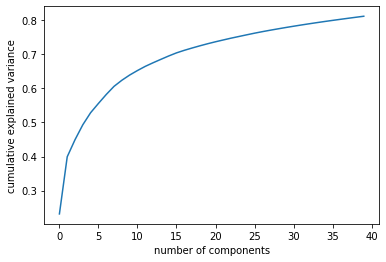

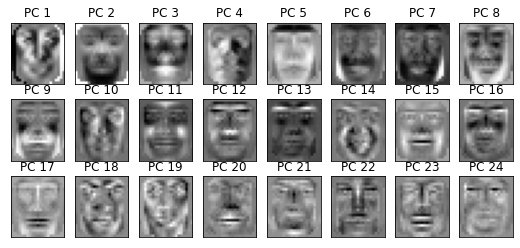


 PCA Components =  40
----------------------------------------------------------------------------------------------------
Training Accuracy Score =  0.8566666666666667
Validation Accuracy Score =  0.81


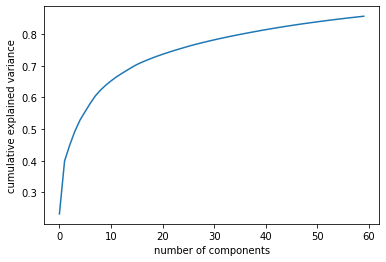

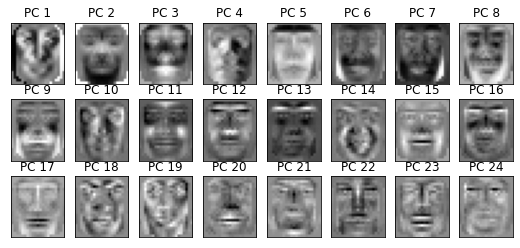


 PCA Components =  60
----------------------------------------------------------------------------------------------------
Training Accuracy Score =  0.8655555555555555
Validation Accuracy Score =  0.8033333333333333


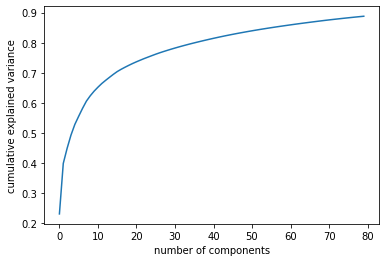

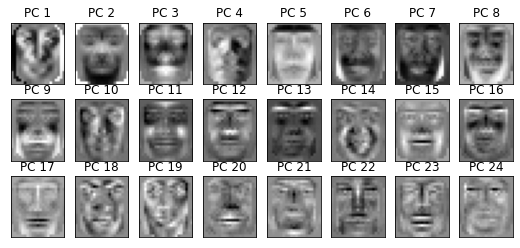


 PCA Components =  80
----------------------------------------------------------------------------------------------------
Training Accuracy Score =  0.8644444444444445
Validation Accuracy Score =  0.7966666666666666


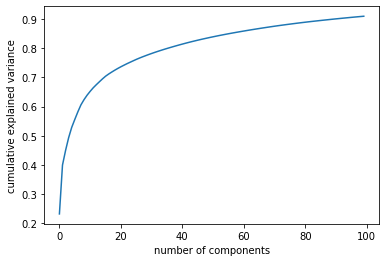

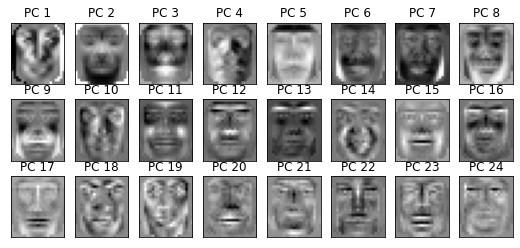


 PCA Components =  100
----------------------------------------------------------------------------------------------------
Training Accuracy Score =  0.8677777777777778
Validation Accuracy Score =  0.7833333333333333


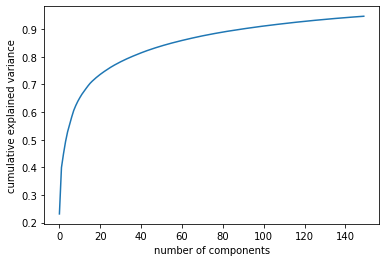

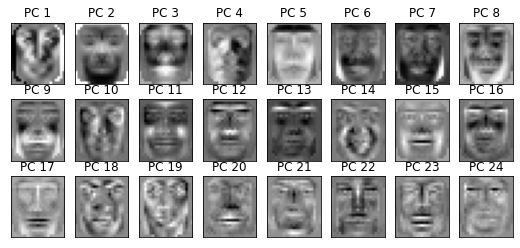


 PCA Components =  150
----------------------------------------------------------------------------------------------------
Training Accuracy Score =  0.8466666666666667
Validation Accuracy Score =  0.7566666666666667


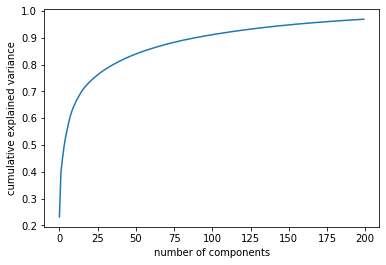

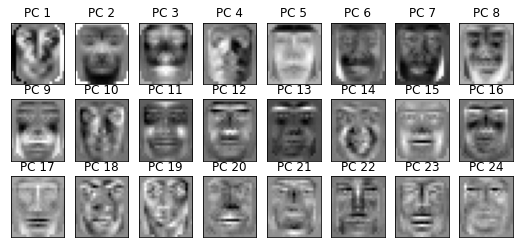


 PCA Components =  200
----------------------------------------------------------------------------------------------------
Training Accuracy Score =  0.84
Validation Accuracy Score =  0.71


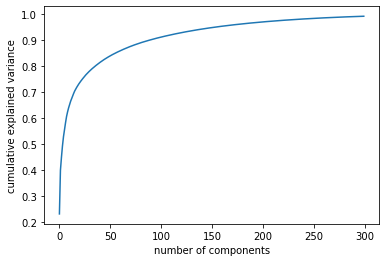

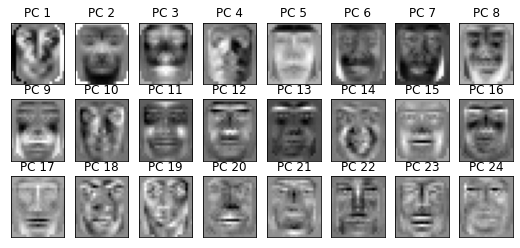


 PCA Components =  300
----------------------------------------------------------------------------------------------------
Training Accuracy Score =  0.8411111111111111
Validation Accuracy Score =  0.6633333333333333


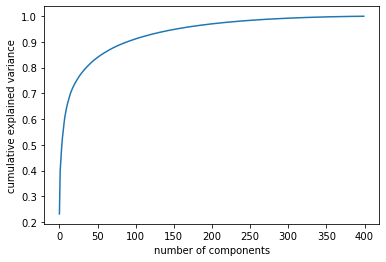

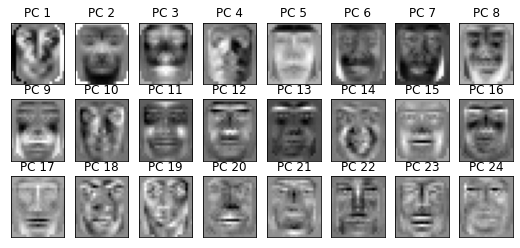


 PCA Components =  400
----------------------------------------------------------------------------------------------------
Training Accuracy Score =  0.8611111111111112
Validation Accuracy Score =  0.6466666666666666


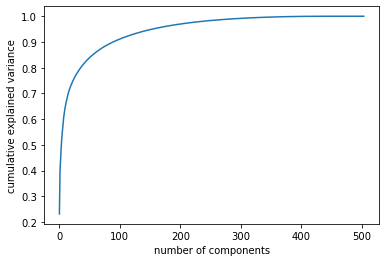

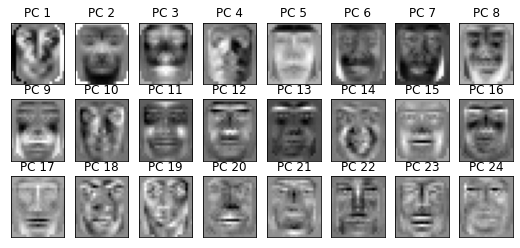


 PCA Components =  504
----------------------------------------------------------------------------------------------------
Training Accuracy Score =  0.8655555555555555
Validation Accuracy Score =  0.4533333333333333


In [101]:
def nb_model(train, val):
  n_comp = [40, 60, 80, 100, 150, 200, 300, 400, 504]
  for comp in n_comp:
    x_train_pca, y_train, x_val_pca, y_val = PCA_analysis(train, val, comp) 
    nb = GaussianNB()
    nb.fit(x_train_pca, np.squeeze(y_train))
    y_pred_val = nb.predict(x_val_pca)
    y_pred_train=nb.predict(x_train_pca)
    print("\n PCA Components = ", comp)
    print("-"*100)
    accuracy_score_val=accuracy_score(y_val, y_pred_val)
    accuracy_score_train=accuracy_score(y_train, y_pred_train)
    print("Training Accuracy Score = ",accuracy_score_train)
    print("Validation Accuracy Score = ",accuracy_score_val)
 
  return nb, x_val_pca, y_val

estimator, x_val, y_val = nb_model(train_df, val_df)
y_pred = estimator.predict(x_val)

In [102]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score

# FUNCTION TO APPLY GRID SEARCH (NAIVE BAYES) ON PCA DATASET

def nb_model(train, val):
  n_comp = [40, 60, 80, 100, 150, 200, 300, 400, 504]                  # For PCA no of components
  n_comp = [0]                                                         # For LDA (no components)
  for comp in n_comp:
    #x_train_pca, y_train, x_val_pca, y_val = PCA_analysis(train, val, comp)    # Applying PCA to dataset
    x_train_mda, y_train, x_val_mda, y_val = lda_analysis(train, val)           # Applying LDA to dataset
    nb = GaussianNB()
    nb.fit(x_train_mda, np.squeeze(y_train))                                    # Fitting Naive Bayes model
    y_pred_val = nb.predict(x_val_mda)
    y_pred_train = nb.predict(x_train_mda)
    print("\n PCA Components = ", comp)
    print("-"*100)
    accuracy_score_val=accuracy_score(y_val, y_pred_val)
    accuracy_score_train=accuracy_score(y_train, y_pred_train)
    print("Training Accuracy Score = ",accuracy_score_train)
    print("Validation Accuracy Score = ",accuracy_score_val)
 
  return nb, x_val_mda, y_val

estimator, x_val, y_val = nb_model(train_df, val_df)
estimator.predict(x_val)

Train Set Shape =  (900, 2)
Val Set Shape =  (300, 2)

 PCA Components =  0
----------------------------------------------------------------------------------------------------
Training Accuracy Score =  0.9966666666666667
Validation Accuracy Score =  0.8766666666666667


array([0., 2., 2., 2., 2., 1., 2., 1., 0., 0., 2., 2., 1., 2., 0., 2., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 2.,
       0., 0., 0., 1., 2., 0., 0., 0., 2., 1., 1., 0., 0., 0., 2., 1., 1.,
       1., 1., 0., 2., 2., 1., 0., 0., 0., 0., 0., 1., 2., 2., 1., 0., 0.,
       2., 2., 2., 1., 2., 2., 1., 1., 2., 0., 0., 1., 0., 2., 2., 0., 2.,
       0., 0., 2., 2., 0., 2., 2., 0., 1., 0., 2., 1., 0., 0., 2., 0., 0.,
       1., 1., 0., 0., 0., 0., 2., 1., 2., 2., 1., 0., 0., 2., 2., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 0., 2., 2., 1., 2., 1., 1., 2., 2.,
       2., 1., 0., 2., 2., 2., 1., 2., 2., 2., 2., 0., 0., 0., 0., 2., 2.,
       0., 2., 0., 2., 1., 1., 1., 0., 0., 2., 2., 1., 1., 1., 0., 2., 0.,
       1., 1., 0., 0., 2., 1., 1., 2., 0., 2., 1., 1., 1., 0., 0., 1., 0.,
       2., 0., 0., 1., 0., 1., 1., 1., 0., 1., 2., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 2., 1., 1., 2., 1., 1., 1., 1., 0., 1., 2., 2., 0., 0.,
       0., 1., 1., 0., 1.

## Support Vector Machine


In [103]:
from sklearn.svm import SVC

# FUNCTION TO APPLY GRID SEARCH (SVM) ON PCA DATASET

def svm_model(train, val):
  n_comp = [40, 60, 80, 100, 150, 200, 300, 400, 504]            # For no of components in PCA
  n_comp = [0]                                                   # For LDA (no components)
  for comp in n_comp:
    #x_train_pca, y_train, x_val_pca, y_val = PCA_analysis(train, val, comp)    # Applying PCA on dataset
    x_train_mda, y_train, x_val_mda, y_val = lda_analysis(train, val)           # Applying LDA on dataset
    svm = SVC()
    params = {"C" : [0.1, 0.2, 0.5, 1, 2, 5, 8, 10, 14],
              "kernel":["rbf", "linear", "poly","sigmoid"],
              "degree" : [3, 5, 7, 9, 13, 16, 20],
              "max_iter":[-1]}                                                  # Parameters to be tuned
    search = GridSearchCV(estimator = svm, param_grid = params, scoring = "accuracy", cv = 2, verbose = 0)   #Initialising GridSearchCV
    search.fit(x_train_mda, np.squeeze(y_train))                                                             #Fitting GridSearchCV
    print("\n PCA Components = ", comp)
    print("-"*100)
    print("Train Accuracy = ", search.best_estimator_.score(x_train_mda, np.squeeze(y_train)))
    print("Validation Accuracy = ", search.best_estimator_.score(x_val_mda, np.squeeze(y_val)))
  
  return search.best_estimator_, x_train_mda, y_train, x_val_mda, y_val

estimator,_,_,x_val, y_val = svm_model(train_df, val_df)
estimator.predict(x_val)

Train Set Shape =  (900, 2)
Val Set Shape =  (300, 2)

 PCA Components =  0
----------------------------------------------------------------------------------------------------
Train Accuracy =  0.9966666666666667
Validation Accuracy =  0.87


array([0., 2., 2., 2., 2., 1., 2., 1., 0., 1., 2., 2., 1., 2., 0., 2., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 2.,
       0., 0., 0., 1., 2., 0., 0., 0., 2., 1., 1., 0., 0., 0., 2., 1., 1.,
       1., 1., 1., 2., 2., 1., 0., 0., 0., 0., 0., 1., 2., 2., 1., 0., 0.,
       2., 2., 2., 1., 2., 2., 1., 1., 2., 0., 0., 1., 0., 2., 2., 0., 2.,
       0., 0., 2., 2., 0., 2., 2., 0., 1., 0., 2., 1., 0., 0., 2., 0., 0.,
       1., 1., 0., 0., 0., 0., 2., 1., 2., 2., 1., 0., 0., 2., 2., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 0., 2., 2., 1., 2., 1., 1., 2., 2.,
       2., 1., 0., 2., 2., 2., 1., 2., 2., 2., 2., 0., 0., 0., 0., 2., 2.,
       0., 2., 0., 2., 1., 1., 1., 0., 0., 2., 2., 1., 1., 1., 0., 2., 0.,
       1., 1., 0., 0., 2., 1., 1., 2., 0., 2., 1., 1., 1., 0., 0., 1., 0.,
       2., 0., 0., 1., 0., 1., 1., 1., 0., 1., 2., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 2., 1., 1., 2., 1., 1., 1., 1., 0., 1., 2., 2., 0., 0.,
       0., 1., 1., 0., 1.

# Pose Dataset

Cropped images of 68 subjects under 13 different poses

In [104]:
#pose = spio.loadmat('/content/drive/MyDrive/Face_Recognition/pose.mat')
pose = spio.loadmat('pose.mat')

In [105]:
pose['pose'].shape

(48, 40, 13, 68)

In [106]:
X = pose['pose'].transpose(3, 2, 1, 0)
X.shape

(68, 13, 40, 48)

In [107]:
np.vstack([np.expand_dims(X[32, 11, :, :], axis=0) for x in range(68) for y in range(13)]).shape

(884, 40, 48)

In [108]:
X = np.vstack([np.expand_dims(X[x, y, :, :], axis=0) for x in range(68) for y in range(13)])
y = np.array([j for i in range(68) for j in range(13)])

In [109]:
X.shape, y.shape

((884, 40, 48), (884,))

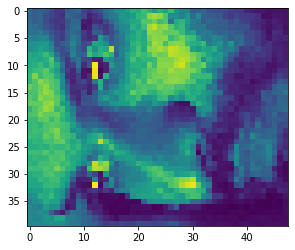

In [110]:
plt.imshow(X[124, :, :])

In [111]:
X = np.vstack([np.concatenate(X[i], axis=0) for i in range(len(X))])

In [112]:
X.shape, y.shape

((884, 1920), (884,))

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### PCA

In [114]:
def show_eigenfaces(pca):
	#Displaying Eigenfaces
	fig, axes = plt.subplots(3, 8, figsize=(9, 4),
	                         subplot_kw={'xticks':[], 'yticks':[]})
	for i, ax in enumerate(axes.flat):
	    ax.imshow(pca.components_[i].reshape(24, 21), cmap='gray')
	    ax.set_title("PC " + str(i+1))
	plt.show()

In [115]:
def apply_PCA(x_train, x_val, pca):
  x_train_pca = pca.transform(x_train)
  x_val_pca = pca.transform(x_val)
  
  return x_train_pca, x_val_pca

def PCA_analysis(X_train, X_test, y_train, y_test, n_comp):
  n_comp = min(n_comp, len(X_train))
  pca = PCA(n_components=n_comp).fit(X_train)
  X_train, X_test = apply_PCA(X_train, X_test, pca)
  return X_train, y_train, X_test, y_test

#x_train_pca, y_train, x_val_pca, y_val = PCA_analysis(train_df, val_df)

#### KNN

In [116]:
def knn_model(X_train, X_test, y_train, y_test):
  n_comp = [40, 60, 80, 100, 150, 200, 300, 400, 504]
  for comp in n_comp:
    with np.errstate(divide='ignore'):
      X_train_pca, y_train, X_val_pca, y_val = PCA_analysis(X_train, X_test, y_train, y_test, comp) 
    knn = KNeighborsClassifier()
    params = {"n_neighbors" : [1, 3, 5, 10],
              "weights" : ["uniform", "distance"],
              "p":[1, 1.5, 2]}
    search = GridSearchCV(estimator = knn, param_grid = params, scoring = "accuracy", cv = 2, verbose = 1)
    search.fit(X_train_pca, np.squeeze(y_train))
    print("\n PCA Components = ", comp)
    print("-"*100)
    print("Train Accuracy = ", search.best_estimator_.score(X_train_pca, np.squeeze(y_train)))
    print("Validation Accuracy = ", search.best_estimator_.score(X_val_pca, np.squeeze(y_val)))
  
  return search.best_estimator_, X_train_pca, y_train, X_val_pca, y_val

estimator,_,_,x_val, y_val = knn_model(X_train, X_test, y_train, y_test)
y_pred = estimator.predict(x_val)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



 PCA Components =  40
----------------------------------------------------------------------------------------------------
Train Accuracy =  0.8344594594594594
Validation Accuracy =  0.7568493150684932
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



 PCA Components =  60
----------------------------------------------------------------------------------------------------
Train Accuracy =  0.847972972972973
Validation Accuracy =  0.75
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



 PCA Components =  80
----------------------------------------------------------------------------------------------------
Train Accuracy =  1.0
Validation Accuracy =  0.7568493150684932
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    2.8s finished



 PCA Components =  100
----------------------------------------------------------------------------------------------------
Train Accuracy =  0.839527027027027
Validation Accuracy =  0.7671232876712328
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    4.2s finished



 PCA Components =  150
----------------------------------------------------------------------------------------------------
Train Accuracy =  0.8192567567567568
Validation Accuracy =  0.7157534246575342
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    5.6s finished



 PCA Components =  200
----------------------------------------------------------------------------------------------------
Train Accuracy =  1.0
Validation Accuracy =  0.6883561643835616
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    8.3s finished



 PCA Components =  300
----------------------------------------------------------------------------------------------------
Train Accuracy =  1.0
Validation Accuracy =  0.6883561643835616
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   11.2s finished



 PCA Components =  400
----------------------------------------------------------------------------------------------------
Train Accuracy =  1.0
Validation Accuracy =  0.6883561643835616
Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   14.1s finished



 PCA Components =  504
----------------------------------------------------------------------------------------------------
Train Accuracy =  1.0
Validation Accuracy =  0.6815068493150684


## KNN (alternate - Vary k to see its effect and discuss it in the report)

In [117]:
pose = load_data('pose.mat','pose')

In [118]:
pose.shape

(48, 40, 13, 68)

In [119]:
def pose_flatten(data):
  train_X, test_X = [],[]
  train_y, test_y = [],[]
  for i in range(data.shape[3]):
    for j in range(data.shape[2]):
      image = data[:,:,j,i]
      pixels = image.flatten()
      if j<10:
        train_X.append(pixels)
        train_y.append(i)
      else:
        test_X.append(pixels)
        test_y.append(i)
  return np.array(train_X), np.array(test_X), np.array(train_y), np.array(test_y)

In [120]:
train_X, test_X, train_y, test_y = pose_flatten(pose)

In [121]:
train_X.shape, test_X.shape

((680, 1920), (204, 1920))

In [122]:
def execute_pose(train_X, test_X, train_y, test_y, dim, model_type):
  pca = PCA(dim)
  train_X = pca.fit_transform(train_X)
  test_X = pca.transform(test_X)
  if model_type[0]=='KNN':
    model = KNeighborsClassifier(n_neighbors=model_type[1])
    model.fit(train_X, train_y)
    acc = model.score(test_X, test_y)
    print("KNN accuracy: {:.2f}%".format(acc * 100))
  if model_type[0]=='NB':
    model = GaussianNB()
    pred_y = model.fit(train_X, train_y).predict(test_X)
    acc = np.mean(test_y==pred_y)
    print("Bayes classifier accuracy: {:.2f}%".format(acc * 100))

In [123]:
execute_pose(train_X, test_X, train_y, test_y, dim=650, model_type=['KNN',1])

KNN accuracy: 61.27%


In [124]:
execute_pose(train_X, test_X, train_y, test_y, dim=250, model_type=['KNN',1])

KNN accuracy: 62.25%


Reducing the dimensions doesn't have much effect on the accuracy of the classifier

In [125]:
execute_pose(train_X, test_X, train_y, test_y, dim=650, model_type=['KNN',3])

KNN accuracy: 34.31%


On increasing the no. of neighbors, the accuracy is affected significantly

In [126]:
execute_pose(train_X, test_X, train_y, test_y, dim=250, model_type=['NB'])

Bayes classifier accuracy: 43.63%


In [127]:
execute_pose(train_X, test_X, train_y, test_y, dim=80, model_type=['NB'])

Bayes classifier accuracy: 53.92%


The accuracy of bayes classifier increased by decreasing the dimension. Here kNN (1 neighbor) is way more accurate than Bayes classifier

#### NAIVE BAYES

In [128]:
def nb_model(X_train, X_test, y_train, y_test):
  n_comp = [40, 60, 80, 100, 150, 200, 300, 400, 504]
  for comp in n_comp:
    with np.errstate(divide='ignore'):
      X_train_pca, y_train, X_val_pca, y_val = PCA_analysis(X_train, X_test, y_train, y_test, comp) 
    nb = GaussianNB()
    nb.fit(X_train_pca, np.squeeze(y_train))
    y_pred_val = nb.predict(X_val_pca)
    y_pred_train=nb.predict(X_train_pca)
    print("\n PCA Components = ", comp)
    print("-"*100)
    accuracy_score_val=accuracy_score(y_val, y_pred_val)
    accuracy_score_train=accuracy_score(y_train, y_pred_train)
    print("Training Accuracy Score = ",accuracy_score_train)
    print("Validation Accuracy Score = ",accuracy_score_val)
 
  return nb, X_val_pca, y_val

estimator, x_val, y_val = nb_model(X_train, X_test, y_train, y_test)
y_pred = estimator.predict(x_val)


 PCA Components =  40
----------------------------------------------------------------------------------------------------
Training Accuracy Score =  0.9408783783783784
Validation Accuracy Score =  0.8595890410958904

 PCA Components =  60
----------------------------------------------------------------------------------------------------
Training Accuracy Score =  0.9662162162162162
Validation Accuracy Score =  0.886986301369863

 PCA Components =  80
----------------------------------------------------------------------------------------------------
Training Accuracy Score =  0.972972972972973
Validation Accuracy Score =  0.8835616438356164

 PCA Components =  100
----------------------------------------------------------------------------------------------------
Training Accuracy Score =  0.9746621621621622
Validation Accuracy Score =  0.8767123287671232

 PCA Components =  150
----------------------------------------------------------------------------------------------------
Trai

In [129]:
# Because there are a total 13 poses for each person, cannot use PCA+MDA+kNN with 68 classes
# because both PCA and MDA are mutually exclusive; only 1 can be used. 
# In this function PCA + Naive Bayes were used intead for each person
# Try to identify a particular pose
# Hence the number of classes is 13.